In [1]:
import numpy as np
from pysr import PySRRegressor
import matplotlib.pyplot as plt
import os
import esr.generation.generator
import pandas as pd
import string
import sympy
import jax
import jax.numpy as jnp
import itertools

Detected Jupyter notebook. Loading juliacall extension. Set `PYSR_AUTOLOAD_EXTENSIONS=no` to disable.


Make data

In [2]:
X.shape, y.shape

NameError: name 'X' is not defined

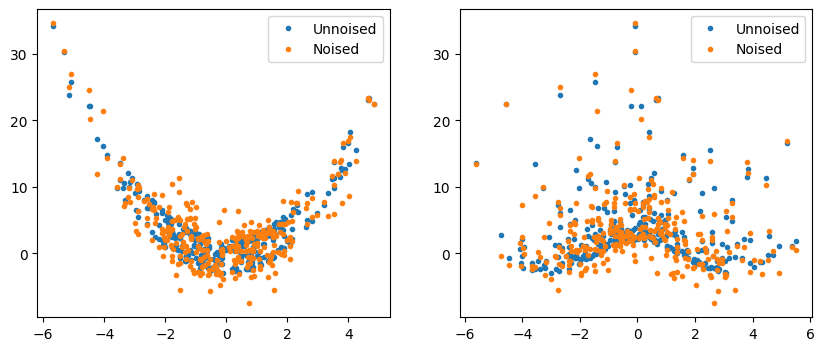

In [12]:
np.random.seed(0)
nsamp = 300

def fx(X):
    return 2.5382 * jnp.cos(X[:, 3]) + X[:, 0] ** 2 - 0.5
    
def fx_jax(X):
    return 2.5382 * jnp.cos(X[3]) + X[0] ** 2 - 0.5

def onejac(fn, X):
    return jax.jacrev(fn)(X)


# generate data and some gradient with error
X = 2 * np.random.randn(nsamp, 5)
y = fx(X)
sigy = np.random.uniform(1.0, 3.0, len(y))

myjac = lambda x: onejac(fx_jax, x)
dy = jax.vmap(myjac)(X)
deltaJ = np.random.uniform(0.5, 0.7, size=(dy.shape))

dy += deltaJ *  np.random.normal(size=dy.shape)

fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].plot(X[:,0], y, '.', label='Unnoised')
axs[1].plot(X[:,3], y, '.', label='Unnoised')
y = y + sigy * np.random.randn(len(y))
axs[0].plot(X[:,0], y, '.', label='Noised')
axs[1].plot(X[:,3], y, '.', label='Noised')
for ax in axs:
    ax.legend()

In [13]:
deltaJ

array([[0.55593576, 0.61633597, 0.59086685, 0.58946458, 0.66414685],
       [0.68477566, 0.59626139, 0.63747036, 0.66021174, 0.60367328],
       [0.55886328, 0.62761692, 0.61702182, 0.68031256, 0.51048141],
       ...,
       [0.69048209, 0.54572367, 0.66744041, 0.56849158, 0.69584867],
       [0.66996353, 0.68098386, 0.6147347 , 0.55883027, 0.539505  ],
       [0.60557438, 0.63430315, 0.64835773, 0.53407664, 0.6071776 ]])

In [6]:
dy.shape

Run PySR with Gaussian loss function

In [7]:
pysr_args = dict(
    binary_operators=["+", "*"],
    unary_operators=[
        "cos",
        "exp",
        "sin",
        "inv(x) = 1/x",
    ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
)
model = PySRRegressor(
    niterations=40,  # < Increase me for better results
    equation_file='my_results_deriv.csv',
    **pysr_args,
)
model.fit(X, y) #, weights=sigy)

/Users/lucas/venvs/pysr/lib/python3.10/site-packages/pysr/sr.py:1309: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


[ Info: Started!


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                     exp(1.2705513)   
	1         1.450437                                            x0 * x0   
	2         0.005882                              0.9530097 * (x0 * x0)   
	3   >>>>  0.278499                                cos(x3) + (x0 * x0)   
	4         0.111059                  (2.5620244 * cos(x3)) + (x0 * x0)   
	5         0.031270  ((cos(x3) * 2.6734772) + (x0 * x0)) + -0.55408543   
	6         0.002576  ((x0 * (x0 * 0.9672052)) + (cos(x3) * 2.673430...   
	7         0.002211  (-0.73536897 * cos(sin(x2))) + ((x0 * x0) + (c...   
	8         0.001739  (x0 * x0) + ((cos(x3) + (sin(5.9833865) * cos(...   
	9         0.002187  sin(sin(cos(x1)) + sin(-1.0618688)) + ((x0 * x...   
	10        0.001614  sin(sin(sin(cos(x1))) + sin(-1.0618688)) + ((x...   
	11        0.001126  ((cos(x3) + (exp(cos(inv(x0 + (x0 * x0)))) * -...   
	12        0.000110  ((cos(x3) + sin(exp(cos(inv(x0 + (x0 * x0)))) ...   
	
	         loss  complexity  
	0   35.307938           2  
	1    8.278573           3  
	2    8.181756           5  
	3    6.192925           6  
	4    4.959421           8  
	5    4.658762          10  
	6    4.634823          12  
	7    4.614370          14  
	8    4.606354          15  
	9    4.596292          16  
	10   4.588880          17  
	11   4.578553          19  
	12   4.578049          20  
]

Load the functions from csv file

In [83]:
import inspect

len(inspect.getfullargspec(fx).args)

In [27]:
def split_by_punctuation(s):
    """
    Convert a string into a list, where the string is split by punctuation,
    excluding underscores or full stops.
    
    For example, the string 'he_ll*o.w0%rl^d' becomes
    ['he_ll', '*', 'o.w0', '%', 'rl', '^', 'd']
    
    Args:
        :s (str): The string to split up
        
    Returns
        :split_str (list[str]): The string split by punctuation
    
    """
    pun = string.punctuation.replace('_', '') # allow underscores in variable names
    pun = string.punctuation.replace('.', '') # allow full stops
    pun = pun + ' '
    where_pun = [i for i in range(len(s)) if s[i] in pun]
    if len(where_pun) > 0:
        split_str = [s[:where_pun[0]]]
        for i in range(len(where_pun)-1):
            split_str += [s[where_pun[i]]]
            split_str += [s[where_pun[i]+1:where_pun[i+1]]]
        split_str += [s[where_pun[-1]]]
        if where_pun[-1] != len(s) - 1:
            split_str += [s[where_pun[-1]+1:]]
    else:
        split_str = [s]
        
    # Remove spaces
    split_str = [s.strip() for s in split_str if len(s) > 0 and (not s.isspace())]
    
    return split_str

def is_float(s):
    """
    Function to determine whether a string has a numeric value
    
    Args:
        :s (str): The string of interest
        
    Returns:
        :bool: True if s has a numeric value, False otherwise
        
    """
    try:
        float(eval(s))
        return True
    except:
        return False

def replace_floats(s):
    """
    Replace the floats in a string by parameters named b0, b1, ...
    where each float (even if they have the same value) is assigned a
    different b.
    
    Args:
        :s (str): The string to consider
        
    Returns:
        :replaced (str): The same string, but with floats replaced by parameter names
        :values (list[float]): The values of the parameters in order [b0, b1, ...]
        
    """
    split_str = split_by_punctuation(s)
    values = []
    
    # Initial pass at replacing floats
    for i in range(len(split_str)):
        if is_float(split_str[i]) and "." in split_str[i]:
            values.append(float(split_str[i]))
            split_str[i] = f'b{len(values)-1}'
        elif len(split_str[i]) > 1 and split_str[i][-1] == 'e' and is_float(split_str[i][:-1]):
            if split_str[i+1] in ['+', '-']:
                values.append(float(''.join(split_str[i:i+3])))
                split_str[i] = f'b{len(values)-1}'
                split_str[i+1] = ''
                split_str[i+2] = ''
            else:
                assert split_str[i+1].is_digit()
                values.append(float(''.join(split_str[i:i+2])))
                split_str[i] = f'b{len(values)-1}'
                split_str[i+1] = ''
    
    # Now check for negative parameters
    for i in range(len(values)):
        idx = split_str.index(f'b{i}')
        if (idx == 1) and (split_str[0] == '-'):
            split_str[0] = ''
            values[i] *= -1
        elif (split_str[idx-1] == '-') and (split_str[idx-2] in ['+','-','*','/','(']):
            values[i] *= -1
            split_str[idx-1] = ''

    # Rejoin string
    replaced = ''.join(split_str)

    return replaced, values


def compute_DL(eq):

    basis_functions = [["x", "b"],  # type0
            ["square", "exp", "inv", "sqrt", "log", "cos"],  # type1
            ["+", "*", "-", "/", "pow"]]  # type2

    a, b = sympy.symbols('a b', real=True)
    sympy.init_printing(use_unicode=True)
    inv = sympy.Lambda(a, 1/a)
    square = sympy.Lambda(a, a*a)
    cube = sympy.Lambda(a, a*a*a)
    sqrt = sympy.Lambda(a, sympy.sqrt(a))
    log = sympy.Lambda(a, sympy.log(a))
    power = sympy.Lambda((a,b), sympy.Pow(a, b))

    sympy_locs = {"inv": inv,
                "square": square,
                "cube": cube,
                "pow": power,
                "Abs": sympy.Abs,
                "sqrt":sqrt,
                "log":log,
                }
    
    expr, pars = replace_floats(eq)
    expr, nodes, c = esr.generation.generator.string_to_node(
        expr, 
        basis_functions, 
        evalf=True, 
        allow_eval=True, 
        check_ops=True, 
        locs=sympy_locs
    )
    param_list = [f"b{i}" for i in range(len(pars))]
    labels = nodes.to_list(basis_functions)
    latex_expr = sympy.latex(expr)
    
    # klog(n) + \sum_i log |c_i|
    aifeyn = esr.generation.generator.aifeyn_complexity(labels, param_list)
    
    # Turn function into callable object
    all_x = ' '.join([f'x{i}' for i in range(X.shape[1])])
    all_x = list(sympy.symbols(all_x, real=True))
    all_b = list(sympy.symbols(param_list, real=True))
    eq_jax = sympy.lambdify(all_b + all_x, expr, modules=["jax"])

    # print(len(all_b))
    # print(inspect.getfullargspec(eq_jax))
    # print(list(range(0, len(inspect.getfullargspec(eq_jax).args)))[len(all_b):])
    
    def myloss(p):
        ypred = eq_jax(*p, *X.T)

        myeq = lambda x1,x2,x3,x4,x5: eq_jax(*p, x1,x2,x3,x4,x5)

        yjac = jax.jacrev(myeq, argnums=list(range(0, X.shape[1])))
        Jpred = jnp.array(jax.vmap(yjac)(*X.T)).T
        return np.sum((y - ypred) ** 2 / 2 ) + np.sum( (dy - Jpred)**2 / 2 / deltaJ**2 ) 


    def derivloss(p):
        ypred = eq_jax(*p, *X.T)

        #myeq = lambda x1,x2,x3,x4,x5: eq_jax(*p, x1,x2,x3,x4,x5)
        myeq = lambda *args: eq_jax(*p, *args)

        yjac = jax.jacrev(myeq, argnums=list(range(0, X.shape[1])))
        Jpred = jnp.array(jax.vmap(yjac)(*X.T)).T
        return np.sum( (dy - Jpred)**2 / 2 / deltaJ**2 ) # / deltaJ**2)  # / sigy ** 2)
    
    neglogL = derivloss(pars) #myloss(pars)
    all_logL[i] = neglogL
    
    if len(pars) == 0:
        param_codelen = 0
    else:
        theta_ML = np.array(pars)

        # Compute loss and Hessian
        hessian_myloss = jax.hessian(myloss)
        I_ii = np.diag(np.array(hessian_myloss(pars)))

        # Check the Hessian is valid
        if np.any(I_ii < 0):
            return c, latex_expr, logL, np.nan
            
        # Remove parameters which do not affect the likelihood or zero parameters
        kept_mask = (I_ii > 0) & (theta_ML != 0)
        theta_ML = theta_ML[kept_mask]
        I_ii = I_ii[kept_mask]
        
        # If the error is bigger than the parameter value, we can just set the
        # precision to the parameter value
        Delta = np.sqrt(12./I_ii)
        nsteps = np.abs(np.array(theta_ML))/Delta
        m = nsteps < 1
        I_ii[m] = 12 / theta_ML[m] ** 2
        
        # Compute parameter part of codelength
        p = len(theta_ML)
        param_codelen = -p/2.*np.log(3.) + np.sum( 0.5*np.log(I_ii) + np.log(abs(np.array(theta_ML))) )
    
    # Combine the terms
    DL = neglogL + aifeyn + param_codelen
    
    return c, latex_expr, neglogL, DL, 

Checking if my_results_deriv.pkl exists...
Loading model from my_results_deriv.pkl
Best equation: (2.5620244 * cos(x3)) + (x0 * x0)


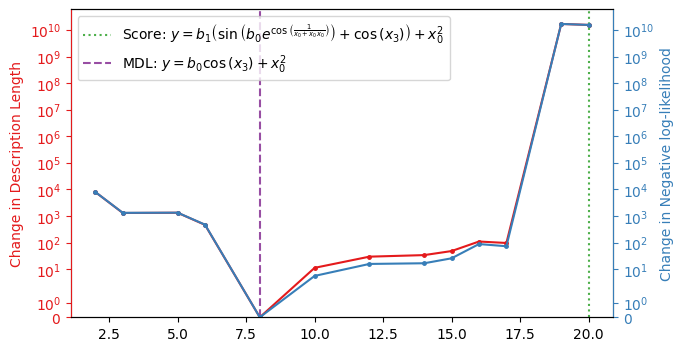

In [28]:
# Find what PySR got as the best one
if os.path.isfile('my_results_deriv.pkl'):
    model = PySRRegressor.from_file('my_results_deriv.pkl')
else:
    model = PySRRegressor.from_file(
        'my_results_deriv.csv',
        nout = 1,
        n_features_in=X.shape[1],
        **pysr_args
    )
hof = model.get_hof()
pysr_ibest = np.argmin(hof['score'][1:]) + 1

# Find what description length (arXiv:2211.11461, Eq. 6) gives
data = pd.read_csv('my_results_deriv.csv')
complexity = np.array(data["Complexity"])
loss = np.array(data["Loss"])
eqs = list(data['Equation'])

all_DL = np.ones(len(eqs)) * np.inf
all_logL = np.ones(len(eqs)) * np.inf
all_latex = [None] * len(eqs)

for i, eq in enumerate(eqs):
    c, all_latex[i], all_logL[i], all_DL[i] = compute_DL(eq)
    
# Only changes in DL and logL matter
all_DL -= np.amin(all_DL)
all_logL -= np.amin(all_logL)

# Print the best found equation
ibest = np.argmin(all_DL)
print('Best equation:', eqs[ibest])

fig, ax1 = plt.subplots(1, 1, figsize=(7,4), sharex=True)
cm = plt.get_cmap('Set1')
ax2 = ax1.twinx()
ax1.plot(complexity, all_DL, marker='.', color=cm(0), markersize=5)
ax2.plot(complexity, all_logL, marker='.', color=cm(1), markersize=5)

ax1.set_ylabel('Change in Description Length')
ax2.set_ylabel('Change in Negative log-likelihood')
ax1.yaxis.label.set_color(cm(0))
ax1.tick_params(axis='y', colors=cm(0))
ax2.spines['left'].set_color(cm(0))

ax2.yaxis.label.set_color(cm(1))
ax2.tick_params(axis='y', colors=cm(1))
ax2.spines['right'].set_color(cm(1))

ax1.set_yscale('symlog')
ax2.set_yscale('symlog')
ax1.set_ylim(0, None)
ax2.set_ylim(0, None)

ax1.axvline(complexity[pysr_ibest], color=cm(2), ls=':', label=r'Score: $y = %s$'%all_latex[pysr_ibest])
ax1.axvline(complexity[ibest], color=cm(3), ls='--', label=r'MDL: $y = %s$'%all_latex[ibest])
ax1.legend()
fig.savefig('function_ranking.png', bbox_inches='tight', facecolor='white')


In [168]:
dy.shape

In [93]:
from sympy.abc import x, y
from sympy import ordered, Matrix, hessian
eq = x**2/2 + 5*y**2 + 2*(x - 2)**4/3 + 8*(y + 1)**4
v = list(ordered(eq.free_symbols)); v

In [96]:
v

In [94]:
gradient = lambda f, v: Matrix([f]).jacobian(v)

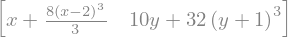

In [95]:
gradient(eq, v)